In [10]:
import numpy as np
import pybamm

import pybop

import matplotlib.pyplot as plt

pybop.plot.PlotlyManager().pio.renderers.default = "notebook_connected"

In [11]:
np.random.seed(8)

# First we create a "experimental data" using the DFN model.

In [12]:
params_DFN = pybamm.ParameterValues("Chen2020")
model_DFN = pybop.models.lithium_ion.DFN(parameter_set=params_DFN)

In [13]:
'''sigma = 0.001
t_eval = np.arange(0, 900, 3)
#Simple discharge experiment
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1C until 3 V",
        )
    ]
)
values = model_DFN.predict(experiment=experiment, t_eval=t_eval)

t_eval = np.arange(0, 1500, 1500/len(values["Time [s]"].data))

corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))

# Form dataset
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

plt.plot(values["Time [s]"].data, values["Voltage [V]"].data, label="Modelled Voltage")
plt.plot(values["Time [s]"].data, corrupt_values, label="Corrupted Voltage")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.title("Voltage Data with Noise")
plt.show()'''

'sigma = 0.001\nt_eval = np.arange(0, 900, 3)\n#Simple discharge experiment\nexperiment = pybamm.Experiment(\n    [\n        (\n            "Discharge at 1C until 3 V",\n        )\n    ]\n)\nvalues = model_DFN.predict(experiment=experiment, t_eval=t_eval)\n\nt_eval = np.arange(0, 1500, 1500/len(values["Time [s]"].data))\n\ncorrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))\n\n# Form dataset\ndataset = pybop.Dataset(\n    {\n        "Time [s]": t_eval,\n        "Current function [A]": values["Current [A]"].data,\n        "Voltage [V]": corrupt_values,\n    }\n)\n\nplt.plot(values["Time [s]"].data, values["Voltage [V]"].data, label="Modelled Voltage")\nplt.plot(values["Time [s]"].data, corrupt_values, label="Corrupted Voltage")\nplt.xlabel("Time [s]")\nplt.ylabel("Voltage [V]")\nplt.legend()\nplt.title("Voltage Data with Noise")\nplt.show()'

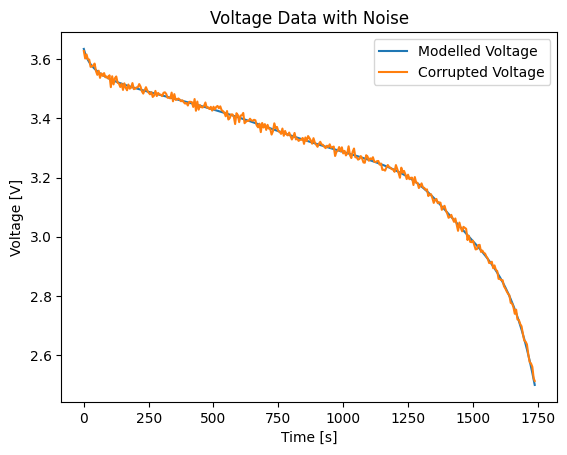

AttributeError: 'DFN' object has no attribute 'quick_plot'

In [ ]:

n_points = 500
sigma = 0.01
t_eval = np.linspace(0, 1600 + 1000, n_points)
current = np.concatenate(
    [np.ones(n_points) * params_DFN["Nominal cell capacity [A.h]"]]
)
initial_state = {"Initial SoC": 0.5}

dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": current,
    }
)

model_DFN.build(dataset=dataset, initial_state=initial_state)
model_DFN.signal = ["Voltage [V]"]
values = model_DFN.simulate(t_eval=t_eval, inputs={})

corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(values["Voltage [V]"].data))

dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": current,
        "Voltage [V]": corrupt_values,
    }
)

plt.plot(values["Time [s]"].data, values["Voltage [V]"].data, label="Modelled Voltage")
plt.plot(values["Time [s]"].data, corrupt_values, label="Corrupted Voltage")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.title("Voltage Data with Noise")
plt.show()


# Now we build the ECM model which will be optimised

In [29]:
parameter_set = pybamm.ParameterValues("ECM_Example")
parameter_set.update(
    {
        "Cell capacity [A.h]": params_DFN["Nominal cell capacity [A.h]"],
        "Nominal cell capacity [A.h]": params_DFN["Nominal cell capacity [A.h]"],
        "Current function [A]": 5,
        "Initial SoC": 1,
        "Element-1 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": params_DFN["Upper voltage cut-off [V]"],
        "Lower voltage cut-off [V]": params_DFN["Lower voltage cut-off [V]"],
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 2e-4,
        "C1 [F]": 1e4,
    }
)
# Optional arguments - only needed for two RC pairs
parameter_set.update(
    {
        "R2 [Ohm]": 0.0003,
        "C2 [F]": 40000,
        "Element-2 initial overpotential [V]": 0,
    },
    check_already_exists=False,
)

In [30]:
model_ECM = pybop.empirical.Thevenin(
    parameter_set=parameter_set, options={"number of rc elements": 2}
)

In [31]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(2 - 4, 1e-4),
        bounds=[1e-4, 1e-2],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(1e-4, 1e-4),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(1e-4, 1e-4),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(1e4, 5e2),
        bounds=[2.5e3, 5e4],
    ),
    pybop.Parameter(
        "C2 [F]",
        prior=pybop.Gaussian(1e4, 5e2),
        bounds=[2.5e3, 5e4],
    ),
)

In [ ]:
problem = pybop.FittingProblem(model_ECM, parameters, dataset)
cost = pybop.SumSquaredError(problem)

ValueError: Time [s] data and Voltage [V] data must be the same length.

In [ ]:
cost([0.001, 0.001, 0.001, 5000, 5000])

18.327980568052133

In [ ]:
optim = pybop.XNES(
    cost,
    sigma0=[1e-4, 1e-4, 1e-4, 10, 10],
    max_unchanged_iterations=50,
    max_iterations=10000,
)
results = optim.run()

In [ ]:
pybop.plot.problem(problem, problem_inputs=results.x, title="Optimised Comparison");

In [ ]:
pybop.plot.convergence(optim)
pybop.plot.parameters(optim);

In [ ]:
pybop.plot.surface(optim, title=optim.cost.problem.model.name)

ValueError: This plot method requires two parameters.